# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull,from_unixtime,instr,when
from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector

from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier,LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer,MaxAbsScaler, IDF, Normalizer, PCA, RegexTokenizer,VectorIndexer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import os.path
from pyspark.ml.pipeline import PipelineModel

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spark") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [4]:
# clean records without userids or sessionids
print(df.count())
df = df.dropna(how = "any",subset = ["userId", "sessionId"])
df = df.filter(df.userId!='')
print(df.count())
# df.show(5)

286500
278154


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
# churn_df = df.filter((df.page=="Cancellation Confirmation")&(df.level.isin("free","paid")))
churn_df = df.filter((df.page=="Cancellation Confirmation")&(df.level.isin("free","paid"))).select("userId").distinct()
# churn_users
# print(churn_df.show(52))
df=df.withColumn("churn",df.userId.isin([(i[0]) for i in churn_df.collect()]).cast("int"))
df=df.withColumn("date_time",from_unixtime(df.ts/1000))

In [6]:
df.filter(df.churn==1).select("userId").distinct().count()

52

Visualization: Churn group vs non chrun group by user level.

In [7]:
c_df= df.select(["churn","userId","level"]).distinct()
c_df.show(5)

+-----+------+-----+
|churn|userId|level|
+-----+------+-----+
|    0|    20| free|
|    0|    78| free|
|    0|200003| paid|
|    0|    39| free|
|    1|   122| free|
+-----+------+-----+
only showing top 5 rows



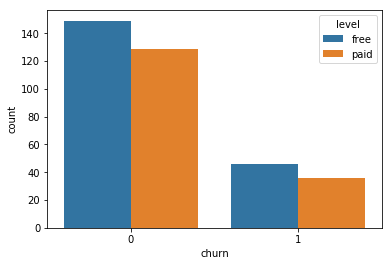

In [8]:
# churn users by level
df_plot = c_df.groupby(["churn", "level"]).count().toPandas()
sns.barplot(x='churn', y='count', hue='level', data=df_plot)

Visualization: Distribution of free and paid users between churn group and non churn group, we cannot find significant difference in between.  

In [9]:
# churn_df = df.filter(df.churn==1).count()
# non_churn_df = df.filter(df.churn==0).count()
df_temp1 = df.groupby(["churn", "page"]).count().withColumnRenamed("count","count_s")
df_temp2 = df.groupby(["page"]).count()
df_temp1=df_temp1.join(df_temp2, ["page"], "left")
df_temp1 = df_temp1.withColumn("prop",df_temp1["count_s"]/df_temp1["count"]).sort("page").toPandas()
df_temp1
# .toPandas()
# vid

,page,churn,count_s,count,prop
0,About,0,439,495,0.886869
1,About,1,56,495,0.113131
2,Add Friend,0,3641,4277,0.851298
3,Add Friend,1,636,4277,0.148702
4,Add to Playlist,0,5488,6526,0.840944
5,Add to Playlist,1,1038,6526,0.159056
6,Cancel,1,52,52,1.000000
7,Cancellation Confirmation,1,52,52,1.000000
8,Downgrade,1,337,2055,0.163990
9,Downgrade,0,1718,2055,0.836010


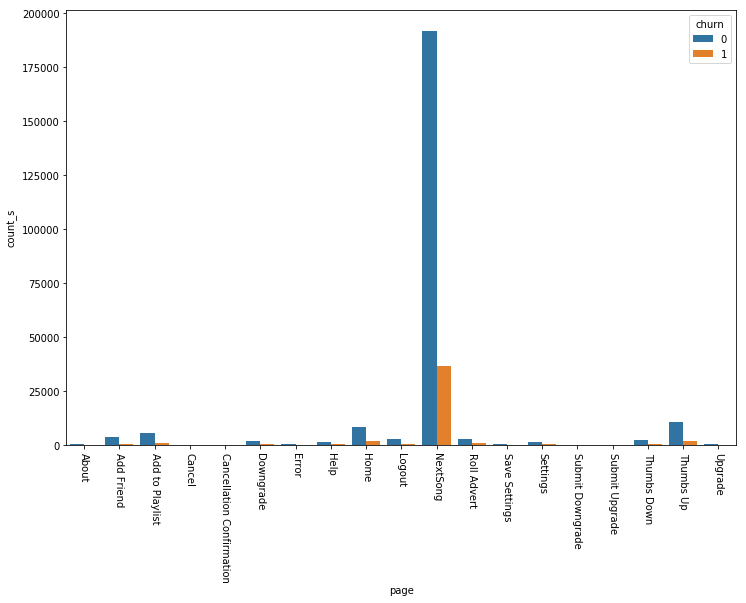

In [10]:
fig = plt.figure(figsize=(12,8))
plt.xticks(rotation=-90)
sns.barplot(x='page', y='count_s', hue='churn', data=df_temp1)
plt.show()
# fig = plt.figure(figsize=(12,4))
# plt.xticks(rotation=-90)
# sns.barplot(x='page', y='prop', hue='churn', data=df_temp1)
# plt.show()

Visualization: By Analyzing the Page type which user had interaction before between churn group and non churn group.From page information, we can find churn users did not like access 'Thumbs up','Home','Add to Playlist','Next Song' usually. 

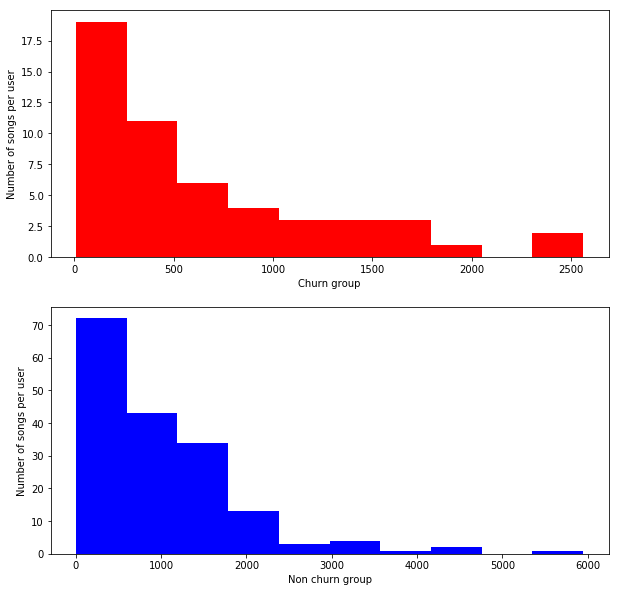

In [11]:
df_temp3 = df.select(["churn","userId","song"]).distinct().where(df["song"].isNotNull()).groupby(["churn","userId"]).count().select(["churn","count"]).toPandas()
# df.select(["churn","userId","song"]).distinct().where(df["song"].isNotNull()).count()
# df.select("userId").distinct().count()
# df.select(["churn","userId","song"]).distinct().where(df.song.isNotNull()).show(20)
# df.select(["churn","userId","song"]).distinct().where(df.userId==4).show(20)
# df.select(["churn","userId","song"]).distinct().where(df["song"].isNotNull()).show(20)
# df_temp3.show(5)
plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
plt.hist(df_temp3[df_temp3['churn']==True]['count'],color="Red")
plt.xlabel('Churn group')  
plt.ylabel('Number of songs per user')
ax2 = plt.subplot(212)
plt.hist(df_temp3[df_temp3['churn']==False]['count'],color="Blue")
plt.xlabel('Non churn group')  
plt.ylabel('Number of songs per user')
plt.show()

Visualization: Played number of songs per user between churn group and non churn group.We could find the churn group only played less than 18 songs usually, non churn group played more than 30 songs usually.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [14]:
df = df.withColumn('new_gender',when(df.gender =='F' ,0).when(df.gender =='M' ,1).otherwise(2))
df = df.withColumn('new_level',when(df.level =='free' ,0).when(df.level =='paid' ,1).otherwise(2))
# df.length

In [15]:
f_length_df=df.groupby("userId").agg(avg(df.length).alias("avgLength"),max(df.length).alias("maxLength"),min(df.length).alias("minLength"))
f_length_df.show(5)

+------+------------------+----------+---------+
|userId|         avgLength| maxLength|minLength|
+------+------------------+----------+---------+
|100010|  243.421444909091| 538.85342| 52.27057|
|200002|242.91699209302305| 592.06485| 26.56608|
|   125|261.13913750000006| 391.26159|178.41587|
|    51|247.88055082899118|2594.87302|  4.04853|
|   124|248.17653659965674|2369.04444| 18.05016|
+------+------------------+----------+---------+
only showing top 5 rows



In [16]:
songs_count_df=df.select(["userId","song"]).distinct().where(df["song"].isNotNull()).groupby(["userId"]).count().withColumnRenamed("count","songs_count")
session_count_df=df.select(["userId","sessionId"]).distinct().where(df["sessionId"].isNotNull()).groupby(["userId"]).count().withColumnRenamed("count","session_count")

In [17]:

f_page_df=df.groupby(["userId","page"]).count().withColumnRenamed("count","page_count").sort("userId")
pages = f_page_df.select('page').distinct().rdd.flatMap(lambda x:x).collect()
exp = [when(f_page_df.page == p,f_page_df.page_count).otherwise(0).alias(str(p)) for p in pages]
f_page_df = f_page_df.select(["userId"]+exp)
f_page_df = f_page_df.groupby('userId').agg(*[max(col(p)).alias(p) for p in pages])
f_page_df.count()

225

In [18]:
user_item= df.groupby(["userId","churn","new_gender"]).agg(max(df.new_level).alias("max_level")).sort("userId")
user_item.show()

+------+-----+----------+---------+
|userId|churn|new_gender|max_level|
+------+-----+----------+---------+
|    10|    0|         1|        1|
|   100|    0|         1|        1|
|100001|    1|         0|        0|
|100002|    0|         0|        1|
|100003|    1|         0|        0|
|100004|    0|         0|        1|
|100005|    1|         1|        0|
|100006|    1|         0|        0|
|100007|    1|         0|        1|
|100008|    0|         0|        1|
|100009|    1|         1|        1|
|100010|    0|         0|        0|
|100011|    1|         1|        0|
|100012|    1|         1|        1|
|100013|    1|         0|        1|
|100014|    1|         1|        1|
|100015|    1|         0|        1|
|100016|    0|         1|        1|
|100017|    1|         1|        0|
|100018|    0|         1|        1|
+------+-----+----------+---------+
only showing top 20 rows



In [19]:
user_item = user_item.join(f_length_df, ["userId"], "left")
user_item = user_item.join(songs_count_df, ["userId"], "left")
user_item = user_item.join(session_count_df, ["userId"], "left") 
user_item = user_item.join(f_page_df, ["userId"], "left")

In [20]:
user_item.count()

225

In [21]:
user_item.persist()
# user_item.show(5)
user_item = user_item.select([p for p in user_item.columns if p not in ["Cancellation Confirmation","Cancel"]]).sort("userId")
# user_item.write.format('csv').option('header',True).mode('overwrite').save("user_item.csv")
user_item

DataFrame[userId: string, churn: int, new_gender: int, max_level: int, avgLength: double, maxLength: double, minLength: double, songs_count: bigint, session_count: bigint, Submit Downgrade: bigint, Thumbs Down: bigint, Home: bigint, Downgrade: bigint, Roll Advert: bigint, Logout: bigint, Save Settings: bigint, About: bigint, Settings: bigint, Add to Playlist: bigint, Add Friend: bigint, NextSong: bigint, Thumbs Up: bigint, Help: bigint, Upgrade: bigint, Error: bigint, Submit Upgrade: bigint]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [22]:
labelIndexer = StringIndexer(inputCol="churn", outputCol="label").fit(user_item)
user_item=VectorAssembler(inputCols=user_item.columns[2:],outputCol="indexFeatures").transform(user_item)


In [23]:
(trainingData, testData) = user_item.randomSplit([0.7, 0.3], seed=6)
trainingData.cache()

DataFrame[userId: string, churn: int, new_gender: int, max_level: int, avgLength: double, maxLength: double, minLength: double, songs_count: bigint, session_count: bigint, Submit Downgrade: bigint, Thumbs Down: bigint, Home: bigint, Downgrade: bigint, Roll Advert: bigint, Logout: bigint, Save Settings: bigint, About: bigint, Settings: bigint, Add to Playlist: bigint, Add Friend: bigint, NextSong: bigint, Thumbs Up: bigint, Help: bigint, Upgrade: bigint, Error: bigint, Submit Upgrade: bigint, indexFeatures: vector]

In [24]:
def rf_model():
    rf = RandomForestClassifier(labelCol="label", featuresCol="indexFeatures")
    # paramGrid = ParamGridBuilder().build()
    paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [1, 3, 5]).addGrid(rf.maxDepth, [3, 5, 7, 10]).addGrid(rf.maxBins, [20, 30, 40]).build()
    # Chain indexers and tree in a Pipeline
    pipeline = Pipeline(stages=[labelIndexer, rf])

    evaluator = MulticlassClassificationEvaluator(metricName='f1')

    cv = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=3)
    # Train model.  This also runs the indexers.
    # model = pipeline.fit(trainingData)
    model= cv.fit(trainingData)
    bestModel = model.bestModel
#     print(bestModel)
#     bestCLModel = bestModel.stages[2]
    bestModel.write().overwrite().save("rf")
#     model.save("rf.model")
    # Make predictions.
    predictions = model.transform(testData)
    return model,predictions,evaluator

In [25]:
if os.path.exists("rf"):
    persistedModel = PipelineModel.load("rf")
    evaluator = MulticlassClassificationEvaluator(metricName='f1')
    predictions = persistedModel.transform(testData)
else:
    rf_model,predictions,evaluator = rf_model()
F1_score = evaluator.evaluate(predictions,{evaluator.metricName: "f1"})
F1_score

0.6732454449669777

In [32]:
def lr_model():
    lr = LogisticRegression(labelCol="label", featuresCol="indexFeatures")
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.elasticNetParam,[0.1, 1.0]) \
        .addGrid(lr.regParam,[0.0, 0.05]) \
        .build()
    # paramGrid = ParamGridBuilder().build()
    # Chain indexers and tree in a Pipeline
    pipeline = Pipeline(stages=[labelIndexer, lr])
    evaluator = MulticlassClassificationEvaluator(metricName='f1')
    cv = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=2)
    # Train model.  This also runs the indexers.
    model= cv.fit(trainingData)
    bestModel = model.bestModel
    bestModel.write().overwrite().save("lr")
    # Make predictions.
    predictions = model.transform(testData)
    return model,predictions,evaluator


In [33]:
if os.path.exists("lr"):
    persistedModel = PipelineModel.load("lr")
    evaluator = MulticlassClassificationEvaluator(metricName='f1')
    predictions = persistedModel.transform(testData)
else:
    lr_model,predictions,evaluator = lr_model()
F1_score = evaluator.evaluate(predictions,{evaluator.metricName: "f1"})
F1_score

0.7005217005217005

In [28]:
def dt_model():
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="indexFeatures")
    paramGrid = ParamGridBuilder() \
        .addGrid(dt.impurity,['entropy', 'gini']) \
        .addGrid(dt.maxDepth,[2,4,6,8]) \
        .build()
    # paramGrid = ParamGridBuilder().build()
    # paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [1, 3, 5]).addGrid(rf.maxDepth, [3, 5, 7, 10]).addGrid(rf.maxBins, [20, 30, 40]).build()
    # Chain indexers and tree in a Pipeline
    pipeline = Pipeline(stages=[labelIndexer, dt])
    evaluator = MulticlassClassificationEvaluator(metricName='f1')
    cv = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=3)
    # Train model.  This also runs the indexers.
    # model = pipeline.fit(trainingData)
    model= cv.fit(trainingData)
    bestModel = model.bestModel
    bestModel.write().overwrite().save("dt")
#     model.save("lr.model")
    # Make predictions.
    predictions = model.transform(testData)
    return model,predictions,evaluator


In [29]:
if os.path.exists("dt"):
    persistedModel = PipelineModel.load("dt")
    evaluator = MulticlassClassificationEvaluator(metricName='f1')
    predictions = persistedModel.transform(testData)
else:
    dt_model,predictions,evaluator = dt_model()
F1_score = evaluator.evaluate(predictions,{evaluator.metricName: "f1"})
F1_score

0.6554334554334554

# Result evaluation 
Here we chose RandomForest, LogisticRegression, DecisionTree as classifiers, F1-score as matrix for evaluation,the F1-score are 0.6732,0.7005,0.6554.Therefore LogisticRegression performed the best among these three models, the best parameter list of lr_model is:
{Param(parent='LogisticRegression_c813d1006a3e', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LogisticRegression_c813d1006a3e', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 1.0, Param(parent='LogisticRegression_c813d1006a3e', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto', Param(parent='LogisticRegression_c813d1006a3e', name='featuresCol', doc='features column name'): 'indexFeatures', Param(parent='LogisticRegression_c813d1006a3e', name='fitIntercept', doc='whether to fit an intercept term'): True, Param(parent='LogisticRegression_c813d1006a3e', name='labelCol', doc='label column name'): 'label', Param(parent='LogisticRegression_c813d1006a3e', name='maxIter', doc='maximum number of iterations (>= 0)'): 100, Param(parent='LogisticRegression_c813d1006a3e', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='LogisticRegression_c813d1006a3e', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities'): 'probability', Param(parent='LogisticRegression_c813d1006a3e', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction', Param(parent='LogisticRegression_c813d1006a3e', name='regParam', doc='regularization parameter (>= 0)'): 0.05, Param(parent='LogisticRegression_c813d1006a3e', name='standardization', doc='whether to standardize the training features before fitting the model'): True, Param(parent='LogisticRegression_c813d1006a3e', name='threshold', doc='threshold in binary classification prediction, in range [0, 1]'): 0.5, Param(parent='LogisticRegression_c813d1006a3e', name='tol', doc='the convergence tolerance for iterative algorithms (>= 0)'): 1e-06}  

These three classifiers had similar F1-score. RandomForest could be a good option because it has faster training speed compare with others, in order to have a better performance, paramGrids were used for each classifier.For RandomForest: rf.numTrees, [1, 3, 5] rf.maxDepth, [3, 5, 7, 10]rf.maxBins, [20, 30, 40]. For LogisticRegression: lr.elasticNetParam,[0.1, 1.0] lr.regParam,[0.0, 0.05]. For DecisionTree: dt.impurity,['entropy', 'gini'] dt.maxDepth,[2,4,6,8] were used for model tuning.
    

# Conclusion

The target was identifying churn user timely and to take actions. Now through this model we can predict if a user might churn according to some features e.g. avgLength,maxLength,minLength,songs_count,session_count,page interactions. Spakify could develop a music recommandation system to analyze user behavior at backend and promoted songs based on individual favorite.

To improve the accuracy further, based on current parameters we can add more hyper-parameters in paramGrid as well as more features in feature engineering step to increase accuracy. 